In [1]:
#from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

In [2]:
class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            self.acceleration = nn.Parameter(tc.randn(N_of_paramater))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
   
def soluçao_OHM(omega_0,gamma,t):
    omega_0 = tc.tensor(omega_0)
    gamma = tc.tensor(gamma)
    return tc.exp(-gamma*t/2) * tc.cos(tc.sqrt(1 - gamma**2/(4*omega_0**2)) * omega_0 * t )

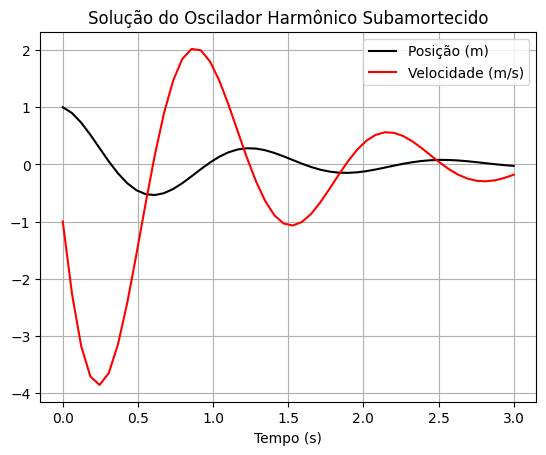

In [12]:
# Criando os dados de treino
t_train = tc.linspace(0,3,50,requires_grad=True).reshape(-1,1)
y_train = soluçao_OHM(omega_0=5,gamma=2,t=t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]

# Plotar a posição em função do tempo
plt.plot(t_train.detach().numpy(), y_train.detach().numpy(),"k-",label='Posição (m)')
plt.plot(t_train.detach().numpy(), v_train.detach().numpy(),"r-",label='Velocidade (m/s)')
plt.xlabel('Tempo (s)')
plt.title('Solução do Oscilador Harmônico Subamortecido')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# Criando os dados de treino
t_train = tc.linspace(0,3,100,requires_grad=True).reshape(-1,1)
y_train = soluçao_OHM(omega_0=5,gamma=2,t=t_train)
v_train = tc.autograd.grad(y_train,t_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]


t_test = tc.linspace(0,3,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(omega_0=5,gamma=2,t=t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

model = Regressao_M(neuronio = 15,M=2,output=2, activation=SineActivation(),creat_p = True,N_of_paramater = 2)
opt = tc.optim.Adam(params=model.parameters(),lr=0.001,betas=(0.9,0.999))
icx = tc.tensor(1)
icv = tc.tensor(0)

print(f"| g0:{model.acceleration.detach()}")

LOSS = []
LOSS2 = []
for epoch in range(30000):
    model.train()

    y_preds = model(t_train)
    solution_x = y_preds[:,0].reshape(-1,1)
    solution_v = y_preds[:,1].reshape(-1,1)

    paramater = model.acceleration
    omega = paramater[0]
    zeta  = paramater[1]
    ###########################################################################
    dxdt = tc.autograd.grad(solution_x,t_train, grad_outputs=tc.ones_like(solution_x), create_graph=True)[0]
    dvdt = tc.autograd.grad(dxdt, t_train, grad_outputs=tc.ones_like(dxdt), create_graph=True)[0]

    # Edo
    loss_ode_dydt = tc.sum( (dxdt - v_train)**2 )

    # Edo
    loss_ode_dvdt = tc.sum( (dvdt + zeta*dxdt + omega**2*solution_x)**2 )

    # Usando os dado experimentais
    loss_datax = tc.mean( (solution_x - y_train )**2 )
    loss_datav = tc.mean( (solution_v - v_train )**2 )

    # Condição inicial x0
    loss_icx = (solution_x[0] - icx)**2

    # Condição inicial v0
    loss_icv = ((dxdt[0] - icv)**2 + (solution_v[0] - icv)**2)/2

    loss = loss_icv + loss_icx + loss_datax+ loss_datav + loss_ode_dvdt +loss_ode_dydt
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    if epoch % 100 == 0 :
        y_preds_test = model(t_test)
        solution_x = y_preds_test[:,0].reshape(-1,1)
        loss2 = tc.sum((solution_x - y_test)**2)
        LOSS2.append(loss2.detach().numpy())
        LOSS.append(loss.detach().numpy())


| g0:tensor([ 0.4326, -0.7231])


| Train Loss: tensor([0.4728]) | g:tensor([5.0227, 2.0094])


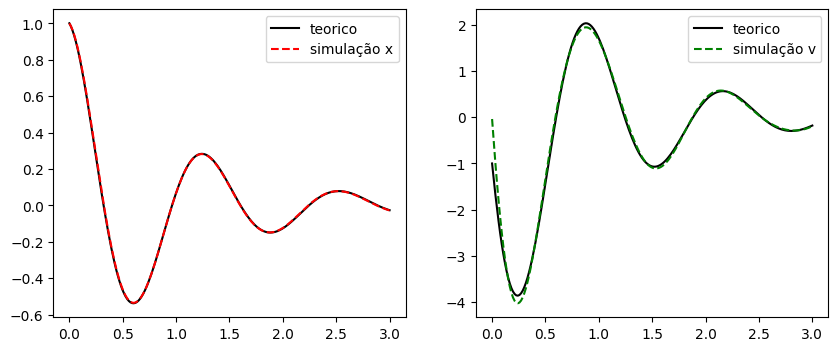

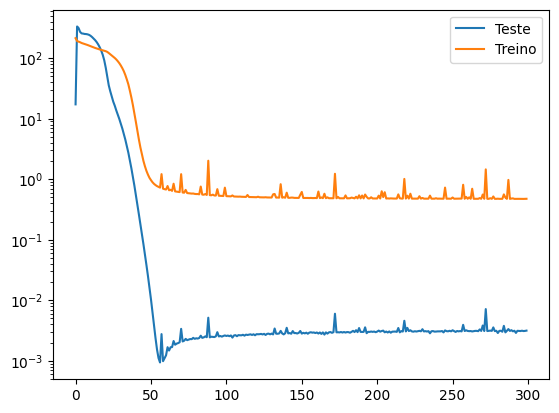

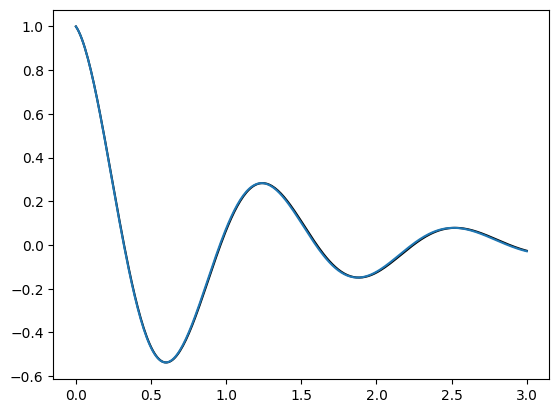

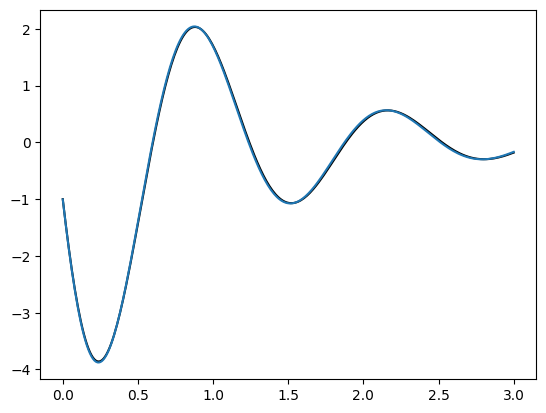

In [14]:
y_preds_test = model(t_test)
solution_x = y_preds_test[:,0].reshape(-1,1)
solution_v = y_preds_test[:,1].reshape(-1,1)

print(f"| Train Loss: {loss.detach()} | g:{model.acceleration.detach()}")

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
ax[0].plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"simulação x" )
ax[0].legend()

ax[1].plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
ax[1].plot(t_test.detach().numpy(), solution_v.detach().numpy(),"g--", label=f"simulação v" )
ax[1].legend()
plt.show()
plt.plot(LOSS2,label="Teste")
plt.plot(LOSS,label="Treino")
plt.legend()
plt.yscale('log')
plt.show()
# ####################Plottd com os parametros
w = model.acceleration.detach().numpy()[0]
gma= model.acceleration.detach().numpy()[1]

t_test = tc.linspace(0,3,300,requires_grad=True).reshape(-1,1)
y_test = soluçao_OHM(omega_0=5,gamma=2,t=t_test)
v_test = tc.autograd.grad(y_test,t_test, grad_outputs=tc.ones_like(y_test), create_graph=True)[0]

y = soluçao_OHM(omega_0=float(w),gamma=float(gma),t=t_test)
v = tc.autograd.grad(y,t_test, grad_outputs=tc.ones_like(y), create_graph=True)[0]

plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="teorico")
plt.plot(t_test.detach().numpy(), y.detach().numpy())
plt.show()

plt.plot(t_test.detach().numpy(), v_test.detach().numpy(),"k-", label="teorico")
plt.plot(t_test.detach().numpy(),v.detach().numpy())

plt.show()